# G8 - Index Tracking optimization

## Import and Data Loading

#### In this section we:
- Import the relevant python packages
- Initialiaze a dictionnary containing all the CAC40 constituents
- Extract relevant stock's data from the last 12 months

In [ ]:
# run the command: pip install [package name] if you get an error on this cell

import numpy as np
import pandas as pd
import yfinance as yf
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
INDEX_CONSTITUENTS = {
    'CAC40': {
        'ticker': '^FCHI',
        'constituents': [
            'AIR.PA', 'AI.PA', 'MT.AS', 'CS.PA', 'BNP.PA', 'EN.PA',
            'CAP.PA', 'CA.PA', 'ACA.PA', 'BN.PA', 'DSY.PA', 'ENGI.PA',
            'EL.PA', 'ERF.PA', 'RMS.PA', 'KER.PA', 'LR.PA', 'OR.PA',
            'MC.PA', 'ML.PA', 'ORA.PA', 'RI.PA', 'PUB.PA', 'RNO.PA',
            'SAF.PA', 'SGO.PA', 'SAN.PA', 'SU.PA', 'GLE.PA', 'STLAP.PA',
            'STMPA.PA', 'TEP.PA', 'HO.PA', 'FP.PA', 'URW.AS', 'VIE.PA',
            'DG.PA', 'VIV.PA', 'WLN.PA', 'ALO.PA'
        ]
    }
}

In [ ]:
def get_index_data(index_name: str,
                   period: str = '1y',
                   constituents: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Fetch daily OHLCV data for an index and its constituents, and return a single DataFrame:
    columns = ['name', 'date', 'open', 'high', 'low', 'close', 'volume']
    """
    index_name = index_name.upper()

    if index_name not in INDEX_CONSTITUENTS:
        raise ValueError(f"Index '{index_name}' not supported. "
                         f"Available: {list(INDEX_CONSTITUENTS.keys())}")

    index_ticker = INDEX_CONSTITUENTS[index_name]['ticker']
    if constituents is None:
        constituents = INDEX_CONSTITUENTS[index_name]['constituents']

    all_rows = []

    def fetch_and_append(ticker, label):
        try:
            df = yf.Ticker(ticker).history(period=period)[['Open','High','Low','Close','Volume']]
            df = df.reset_index().rename(columns=str.lower)
            df['name'] = label
            all_rows.append(df[['name','date','open','high','low','close','volume']])
            print(f"✓ {label}")
        except Exception as e:
            print(f"✗ {label} - {e}")

    # Index itself
    print(f"Fetching index: {index_name}")
    fetch_and_append(index_ticker, index_name)

    # Constituents
    print(f"Fetching {len(constituents)} constituents...")
    for t in constituents:
        fetch_and_append(t, t)

    # Combine all
    big_df = pd.concat(all_rows, ignore_index=True)
    print(f"\nFinal dataset: {big_df['name'].nunique()} assets, {len(big_df):,} rows")

    return big_df

cac40_df = get_index_data('CAC40', period='1y')

Fetching index: CAC40
✓ CAC40
Fetching 40 constituents...
✓ AIR.PA
✓ AI.PA
✓ MT.AS
✓ CS.PA
✓ BNP.PA
✓ EN.PA
✓ CAP.PA
✓ CA.PA
✓ ACA.PA
✓ BN.PA
✓ DSY.PA
✓ ENGI.PA
✓ EL.PA
✓ ERF.PA
✓ RMS.PA
✓ KER.PA
✓ LR.PA
✓ OR.PA
✓ MC.PA
✓ ML.PA
✓ ORA.PA
✓ RI.PA
✓ PUB.PA
✓ RNO.PA
✓ SAF.PA
✓ SGO.PA
✓ SAN.PA
✓ SU.PA
✓ GLE.PA
✓ STLAP.PA
✓ STMPA.PA
✓ TEP.PA
✓ HO.PA


$FP.PA: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


✓ FP.PA


$URW.AS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


✓ URW.AS
✓ VIE.PA
✓ DG.PA
✓ VIV.PA
✓ WLN.PA
✓ ALO.PA

Final dataset: 39 assets, 9,984 rows


## Step 1 — Load CAC40 data

We load the daily returns for:
- the CAC40 index (used as benchmark, `rb`)
- its 40 constituent stocks (as `X`, the explanatory assets)

Each row = trading day, each column in `X` = stock return.


In [ ]:
price_df = cac40_df.pivot(index='date', columns='name', values='close').sort_index()
ret_df = price_df.pct_change().dropna()

# Separate index and constituents
index_name = 'CAC40'
rb = ret_df[index_name].values
X = ret_df.drop(columns=[index_name]).values

T, N = X.shape
print(f"Data loaded: {T} days, {N} constituent stocks.")

Data loaded: 255 days, 38 constituent stocks.


## Step 2 — Initialize the sparse index-tracking model

We set parameters and precompute constants used in the MM algorithm:
- λ : sparsity penalty (higher → fewer assets)
- p, γ : smoothing parameters for the log-approximation
- u : maximum weight per stock (constraint)

In [ ]:
# Parameters
lambda_pen = 0.01 # arbitrary starting value
p = 1e-4
u = 0.1
gamma = u
max_mm_iters = 200
tol_w = 1e-8
bisection_tol = 1e-10

# Precompute matrices
L1 = (X.T @ X) / float(T)
xtrb = (X.T @ rb) / float(T)

# Initialize weights (uniform feasible)
w = np.minimum(np.ones(N) / N, u)
w = w / w.sum()

# Largest eigenvalue estimate
def estimate_largest_eig(A, niter=100):
    v = np.random.randn(A.shape[0])
    v /= np.linalg.norm(v)
    for _ in range(niter):
        v = A @ v
        v /= np.linalg.norm(v)
    return v @ (A @ v)

L1_max = estimate_largest_eig(L1)
kappa = np.log(1 + gamma / p)


/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:11: RuntimeWarning: divide by zero encountered in matmul
  L1 = (X.T @ X) / float(T)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:11: RuntimeWarning: overflow encountered in matmul
  L1 = (X.T @ X) / float(T)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:11: RuntimeWarning: invalid value encountered in matmul
  L1 = (X.T @ X) / float(T)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:12: RuntimeWarning: divide by zero encountered in matmul
  xtrb = (X.T @ rb) / float(T)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:12: RuntimeWarning: overflow encountered in matmul
  xtrb = (X.T @ rb) / float(T)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1497152069.py:12: RuntimeWarning: invalid value encountered in matmul
  xtrb = (X.T @ rb) / float(T)
/var/folders/bs/0_7wd3vj4jq

## Step 3 — Run the MM sparse index-tracking algorithm

At each iteration:
1. Compute the linear surrogate weights $( d_i^{(k)} = 1 / [\kappa(p + w_i^{(k)})]$)
2. Form $( q^{(k)})$ as in the paper (Eq. 25)
3. Solve $( \min_{w \in W_u} w^\top w + q^\top w$) with
   $( w_i = \text{clip}(-0.5(\mu + q_i), 0, u))$
   where μ is chosen so that sum(w)=1
4. Update \( w \), check convergence, and record nonzero positions


In [ ]:
history = {'obj': [], 'nnz': [], 'w_diff': []}

for it in range(max_mm_iters):
    d = 1.0 / (kappa * (p + w))
    term_quad = 2.0 * ((L1 - L1_max * np.eye(N)) @ w)
    term_linear = -2.0 * xtrb
    q = (term_quad + lambda_pen * d + term_linear) / (lambda_pen * L1_max)

    # Bisection on μ for projection
    mu_low, mu_high = -1e6, 1e6
    def sum_for_mu(mu):
        w_cand = np.clip(-0.5 * (mu + q), 0, u)
        return w_cand.sum()

    for _ in range(200):
        mu_mid = 0.5 * (mu_low + mu_high)
        s_mid = sum_for_mu(mu_mid)
        if abs(s_mid - 1) < bisection_tol:
            mu = mu_mid
            break
        if s_mid > 1:
            mu_low = mu_mid
        else:
            mu_high = mu_mid
    else:
        mu = mu_mid

    w_new = np.clip(-0.5 * (mu + q), 0, u)
    w_new /= w_new.sum()

    w_diff = np.linalg.norm(w_new - w)
    obj = np.sum((X @ w_new - rb)**2) / T + lambda_pen * np.sum(np.log(1 + w_new/p)) / kappa

    history['obj'].append(obj)
    history['nnz'].append(np.sum(w_new > 1e-6))
    history['w_diff'].append(w_diff)

    if w_diff < tol_w:
        print(f"Converged at iteration {it}")
        break
    w = w_new

# Results
selected = np.where(w > 1e-6)[0]
selected_stocks = ret_df.drop(columns=[index_name]).columns[selected]
print(f"Selected {len(selected_stocks)} stocks:")
for s, wt in zip(selected_stocks, w[selected]):
    print(f"{s:10s} {wt:.4f}")


Converged at iteration 0
Selected 10 stocks:
AI.PA      0.1000
AIR.PA     0.1000
CS.PA      0.1000
EL.PA      0.1000
LR.PA      0.1000
MC.PA      0.1000
RMS.PA     0.1000
SAF.PA     0.1000
SAN.PA     0.1000
SU.PA      0.1000


/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/2341825721.py:5: RuntimeWarning: divide by zero encountered in matmul
  term_quad = 2.0 * ((L1 - L1_max * np.eye(N)) @ w)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/2341825721.py:5: RuntimeWarning: overflow encountered in matmul
  term_quad = 2.0 * ((L1 - L1_max * np.eye(N)) @ w)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/2341825721.py:5: RuntimeWarning: invalid value encountered in matmul
  term_quad = 2.0 * ((L1 - L1_max * np.eye(N)) @ w)
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/2341825721.py:32: RuntimeWarning: divide by zero encountered in matmul
  obj = np.sum((X @ w_new - rb)**2) / T + lambda_pen * np.sum(np.log(1 + w_new/p)) / kappa
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/2341825721.py:32: RuntimeWarning: overflow encountered in matmul
  obj = np.sum((X @ w_new - rb)**2) / T + lambda_pen * np.sum(np.log(1 + w_new/p)) / kappa
/va

/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1839113576.py:2: RuntimeWarning: divide by zero encountered in matmul
  rp = X @ w    # synthetic portfolio returns
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1839113576.py:2: RuntimeWarning: overflow encountered in matmul
  rp = X @ w    # synthetic portfolio returns
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1839113576.py:2: RuntimeWarning: invalid value encountered in matmul
  rp = X @ w    # synthetic portfolio returns


📈 PERFORMANCE METRICS
Tracking Error (ann.): 5.0758%
Active Return:         11.8964%
Information Ratio:     0.142
Number of stocks:      10


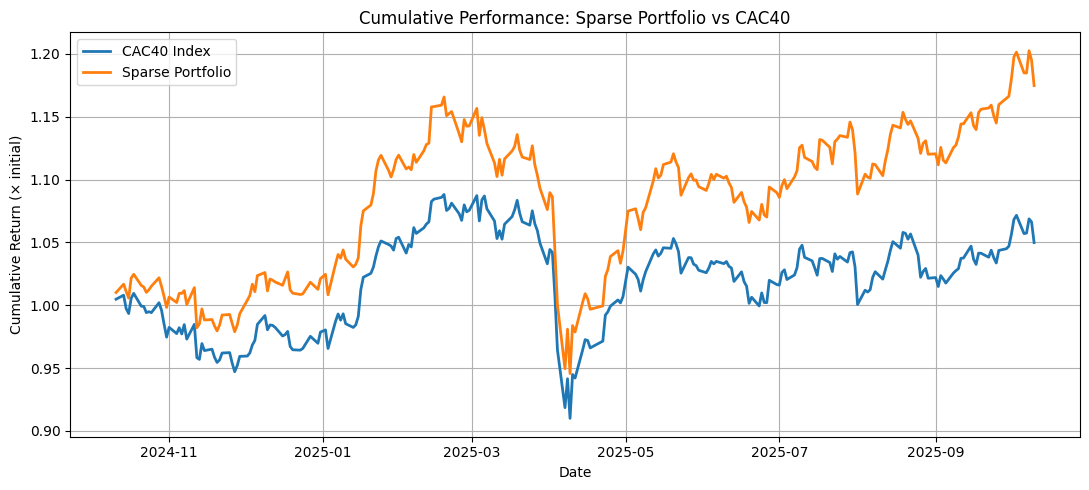

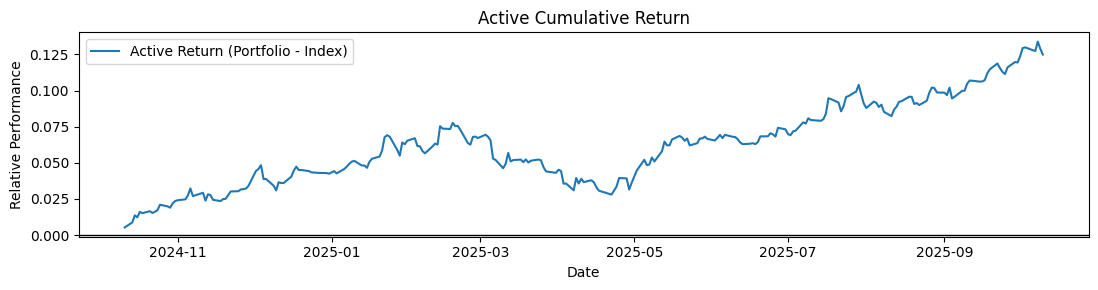

In [ ]:
# 1️⃣ Compute portfolio daily returns (using final weights)
rp = X @ w    # synthetic portfolio returns

# 2️⃣ Compute cumulative returns for both portfolio and index
cum_port = (1 + pd.Series(rp, index=ret_df.index)).cumprod()
cum_index = (1 + pd.Series(rb, index=ret_df.index)).cumprod()

# 3️⃣ Compute performance metrics
tracking_error = np.std(rp - rb) * np.sqrt(252)         # annualized TE
active_return = (cum_port.iloc[-1] - cum_index.iloc[-1]) / cum_index.iloc[-1]
information_ratio = (rp.mean() - rb.mean()) / np.std(rp - rb)

print("📈 PERFORMANCE METRICS")
print(f"Tracking Error (ann.): {tracking_error:.4%}")
print(f"Active Return:         {active_return:.4%}")
print(f"Information Ratio:     {information_ratio:.3f}")
print(f"Number of stocks:      {np.sum(w > 1e-6)}")

# 4️⃣ Plot cumulative performance
plt.figure(figsize=(11,5))
plt.plot(cum_index, label="CAC40 Index", linewidth=2)
plt.plot(cum_port, label="Sparse Portfolio", linewidth=2)
plt.title("Cumulative Performance: Sparse Portfolio vs CAC40")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (× initial)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5️⃣ Plot active return (difference)
plt.figure(figsize=(11,3))
plt.plot(cum_port - cum_index, label="Active Return (Portfolio - Index)")
plt.axhline(0, color='black', lw=1)
plt.title("Active Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Relative Performance")
plt.legend()
plt.tight_layout()
plt.show()

📊 PERFORMANCE METRICS



/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1203424217.py:2: RuntimeWarning: divide by zero encountered in matmul
  rp = X @ w                           # portfolio returns
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1203424217.py:2: RuntimeWarning: overflow encountered in matmul
  rp = X @ w                           # portfolio returns
/var/folders/bs/0_7wd3vj4jq_mljj1xzw70nh0000gn/T/ipykernel_8899/1203424217.py:2: RuntimeWarning: invalid value encountered in matmul
  rp = X @ w                           # portfolio returns


,Annual Return,Annual Volatility,Tracking Error,Information Ratio
Sparse Portfolio,0.1726,0.1786,0.0508,0.142
CAC40 Index,0.0493,0.1590,NaN,NaN


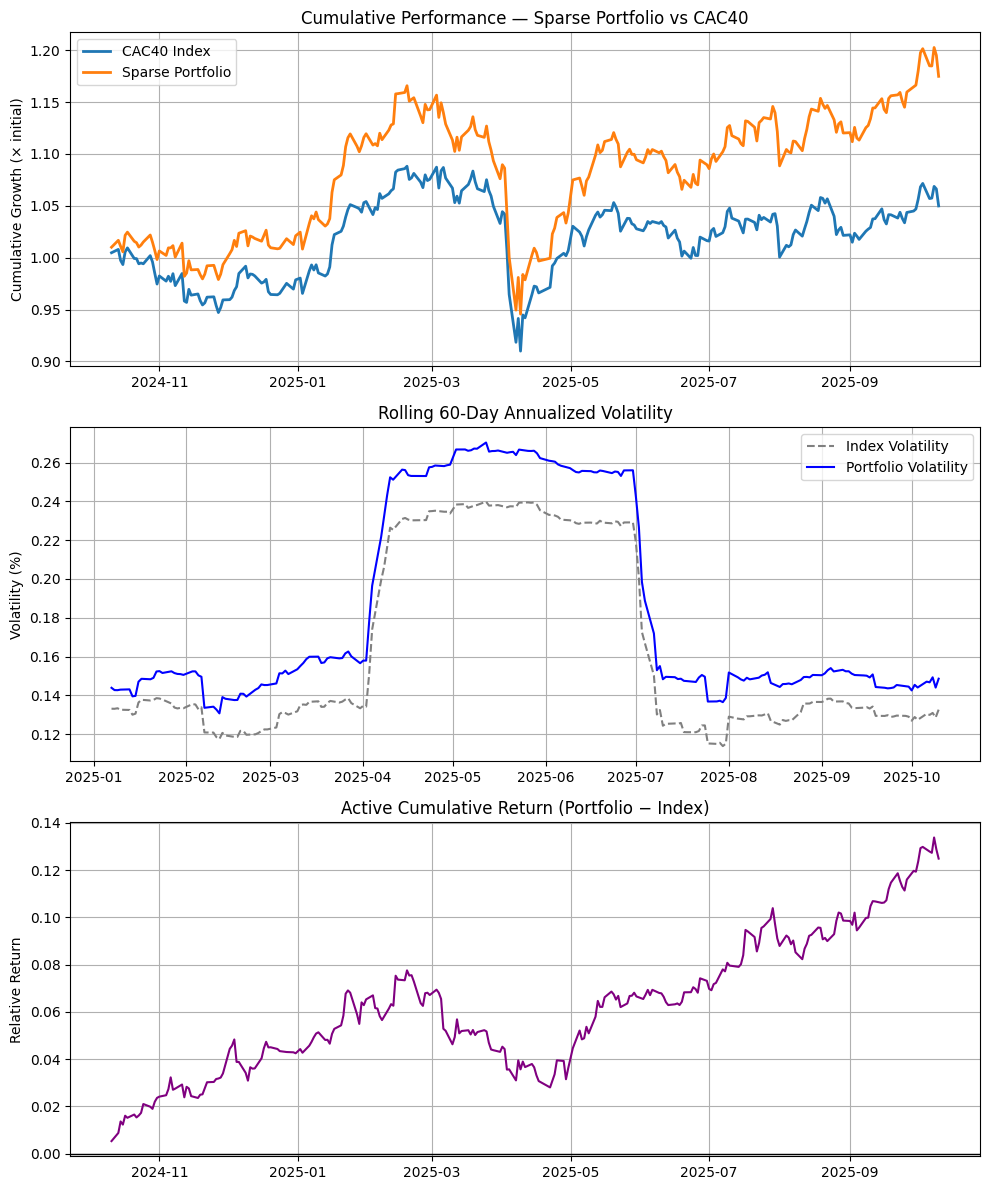

In [ ]:
# === 1️⃣ Compute portfolio & index daily returns and cumulative returns ===
rp = X @ w                           # portfolio returns
rb_series = pd.Series(rb, index=ret_df.index)
rp_series = pd.Series(rp, index=ret_df.index)

cum_index = (1 + rb_series).cumprod()
cum_port  = (1 + rp_series).cumprod()

# === 2️⃣ Annualized metrics ===
ann_factor = np.sqrt(252)  # assuming 252 trading days

def ann_return(r):
    return ((1 + r).prod() ** (252 / len(r)) - 1)*100

def ann_vol(r):
    return r.std() * ann_factor

tracking_error = np.std(rp - rb) * ann_factor
active_return = ann_return(rp - rb)
information_ratio = (rp.mean() - rb.mean()) / np.std(rp - rb)

metrics = pd.DataFrame({
    "Annual Return": [ann_return(rp), ann_return(rb)],
    "Annual Volatility": [ann_vol(rp), ann_vol(rb)],
    "Tracking Error": [tracking_error, np.nan],
    "Information Ratio": [information_ratio, np.nan],
}, index=["Sparse Portfolio", "CAC40 Index"])

print("📊 PERFORMANCE METRICS\n")
display(metrics.round(4))

# === 3️⃣ Rolling volatility (60-day window) ===
roll_vol_port = rp_series.rolling(60).std() * ann_factor
roll_vol_idx  = rb_series.rolling(60).std() * ann_factor

# === 4️⃣ Plots ===

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# --- (a) cumulative performance ---
axes[0].plot(cum_index, label="CAC40 Index", linewidth=2)
axes[0].plot(cum_port, label="Sparse Portfolio", linewidth=2)
axes[0].set_title("Cumulative Performance — Sparse Portfolio vs CAC40")
axes[0].set_ylabel("Cumulative Growth (× initial)")
axes[0].legend()
axes[0].grid(True)

# --- (b) rolling volatility comparison ---
axes[1].plot(roll_vol_idx, label="Index Volatility", color="grey", linestyle="--")
axes[1].plot(roll_vol_port, label="Portfolio Volatility", color="blue")
axes[1].set_title("Rolling 60-Day Annualized Volatility")
axes[1].set_ylabel("Volatility (%)")
axes[1].legend()
axes[1].grid(True)

# --- (c) active return (difference of cumulative) ---
axes[2].plot(cum_port - cum_index, color="purple")
axes[2].axhline(0, color="black", lw=1)
axes[2].set_title("Active Cumulative Return (Portfolio − Index)")
axes[2].set_ylabel("Relative Return")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# TO SKIP - Alternative model (not following paper)



In [ ]:
cac40_df['daily_return_pct'] = cac40_df['close'].pct_change()

In [ ]:
from typing import Tuple, List, Dict
def separate_stocks_and_index(cac40_df: pd.DataFrame, index_name: str = 'CAC40') -> Tuple[pd.DataFrame, pd.DataFrame]:

    index_df = cac40_df[cac40_df['name'] == index_name].copy()
    stocks_df = cac40_df[cac40_df['name'] != index_name].copy()

    print(f"Data loaded:")
    print(f"  - Index rows: {len(index_df)}")
    print(f"  - Stock rows: {len(stocks_df)}")
    print(f"  - Unique stocks: {stocks_df['name'].nunique()}")

    return stocks_df, index_df

In [ ]:
import pandas as pd
import numpy as np
import random
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')


def separate_stocks_and_index(cac40_df: pd.DataFrame, index_name: str = 'CAC40') -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Separate stocks and index from the main dataframe.

    Parameters:
    -----------
    cac40_df : pd.DataFrame
        DataFrame with columns: ['date', 'name', 'open', 'close', 'volume', 'max', 'min', 'daily_return_pct', ...]
    index_name : str
        The name used to identify the index in the 'name' column

    Returns:
    --------
    stocks_df, index_df : Tuple of DataFrames
    """
    index_df = cac40_df[cac40_df['name'] == index_name].copy()
    stocks_df = cac40_df[cac40_df['name'] != index_name].copy()

    print(f"Data loaded:")
    print(f"  - Index rows: {len(index_df)}")
    print(f"  - Stock rows: {len(stocks_df)}")
    print(f"  - Unique stocks: {stocks_df['name'].nunique()}")

    return stocks_df, index_df


def filter_eligible_stocks(stocks_df: pd.DataFrame, index_df: pd.DataFrame) -> List[str]:
    """
    Filter stocks based on:
    1. Positive correlation with the index
    2. Positive average daily return

    Parameters:
    -----------
    stocks_df : pd.DataFrame
        DataFrame containing stock data
    index_df : pd.DataFrame
        DataFrame containing index data

    Returns:
    --------
    List of eligible stock names
    """
    # Pivot data to have stocks as columns
    stock_returns = stocks_df.pivot(
        index='date',
        columns='name',
        values='daily_return_pct'
    )

    # Align dates with index
    index_returns = index_df.set_index('date')['daily_return_pct']
    common_dates = stock_returns.index.intersection(index_returns.index)

    stock_returns = stock_returns.loc[common_dates]
    index_returns = index_returns.loc[common_dates]

    eligible = []
    filtered_stats = []

    for stock in stock_returns.columns:
        stock_data = stock_returns[stock].dropna()

        # Check average return is positive
        avg_return = stock_data.mean()

        # Check correlation with index is positive
        aligned_index = index_returns.loc[stock_data.index]
        correlation = stock_data.corr(aligned_index)

        filtered_stats.append({
            'stock': stock,
            'avg_return': avg_return,
            'correlation': correlation,
            'eligible': (avg_return > 0 and correlation > 0)
        })

        if avg_return > 0 and correlation > 0:
            eligible.append(stock)

    print(f"\n{'='*80}")
    print(f"STOCK FILTERING RESULTS")
    print(f"{'='*80}")
    print(f"Eligible stocks: {len(eligible)} out of {len(stock_returns.columns)}")
    print(f"\nFiltered OUT stocks:")
    filtered_out = [s for s in filtered_stats if not s['eligible']]
    for s in filtered_out:
        reason = []
        if s['avg_return'] <= 0:
            reason.append(f"negative return ({s['avg_return']:.4%})")
        if s['correlation'] <= 0:
            reason.append(f"negative correlation ({s['correlation']:.4f})")
        print(f"  - {s['stock']}: {', '.join(reason)}")

    print(f"\nEligible stocks:")
    for s in [s for s in filtered_stats if s['eligible']]:
        print(f"  - {s['stock']}: return={s['avg_return']:.4%}, corr={s['correlation']:.4f}")

    return eligible


def calculate_portfolio_metrics(stock_subset: List[str], stocks_df: pd.DataFrame,
                                index_df: pd.DataFrame) -> Dict:
    """
    Calculate portfolio metrics for a given subset of stocks.
    Uses equal weighting for simplicity.

    Parameters:
    -----------
    stock_subset : List[str]
        List of stock names in the portfolio
    stocks_df : pd.DataFrame
        DataFrame containing stock data
    index_df : pd.DataFrame
        DataFrame containing index data

    Returns:
    --------
    Dictionary with metrics: tracking_error, portfolio_return, portfolio_vol,
    index_return, index_vol
    """
    # Get returns for selected stocks
    stock_returns = stocks_df[
        stocks_df['name'].isin(stock_subset)
    ].pivot(index='date', columns='name', values='daily_return_pct')

    # Get index returns
    index_returns = index_df.set_index('date')['daily_return_pct']

    # Align dates
    common_dates = stock_returns.index.intersection(index_returns.index)
    stock_returns = stock_returns.loc[common_dates]
    index_returns = index_returns.loc[common_dates]

    # Calculate equal-weighted portfolio returns
    portfolio_returns = stock_returns.mean(axis=1)

    # Remove NaN values
    valid_idx = ~(portfolio_returns.isna() | index_returns.isna())
    portfolio_returns = portfolio_returns[valid_idx]
    index_returns = index_returns[valid_idx]

    # Calculate tracking error (RMSE of difference)
    tracking_diff = portfolio_returns - index_returns
    tracking_error = np.sqrt((tracking_diff ** 2).mean())

    # Calculate annualized metrics (assuming 252 trading days)
    portfolio_return = portfolio_returns.mean() * 252
    portfolio_vol = portfolio_returns.std() * np.sqrt(252)

    index_return = index_returns.mean() * 252
    index_vol = index_returns.std() * np.sqrt(252)

    return {
        'stocks': stock_subset,
        'n_stocks': len(stock_subset),
        'tracking_error': tracking_error,
        'portfolio_return': portfolio_return,
        'portfolio_volatility': portfolio_vol,
        'index_return': index_return,
        'index_volatility': index_vol,
        'return_diff': portfolio_return - index_return,
        'vol_diff': portfolio_vol - index_vol
    }


def run_optimization(eligible_stocks: List[str], stocks_df: pd.DataFrame,
                     index_df: pd.DataFrame, min_assets: int, max_assets: int,
                     n_iterations: int, random_seed: int = None) -> pd.DataFrame:
    """
    Run optimization to find best stock combinations.

    Parameters:
    -----------
    eligible_stocks : List[str]
        List of eligible stock names
    stocks_df : pd.DataFrame
        DataFrame containing stock data
    index_df : pd.DataFrame
        DataFrame containing index data
    min_assets : int
        Minimum number of assets in portfolio
    max_assets : int
        Maximum number of assets in portfolio
    n_iterations : int
        Number of random combinations to test
    random_seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    DataFrame with all tested combinations and their metrics
    """
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    n_eligible = len(eligible_stocks)

    if max_assets > n_eligible:
        print(f"Warning: max_assets ({max_assets}) > eligible stocks ({n_eligible})")
        max_assets = n_eligible

    print(f"\n{'='*80}")
    print(f"RUNNING OPTIMIZATION")
    print(f"{'='*80}")
    print(f"  - Portfolio size range: {min_assets} to {max_assets} stocks")
    print(f"  - Iterations: {n_iterations}")
    print(f"  - Eligible stocks: {n_eligible}")

    results = []

    for i in range(n_iterations):
        # Random portfolio size
        n_stocks = random.randint(min_assets, max_assets)

        # Random stock selection
        stock_subset = random.sample(eligible_stocks, n_stocks)

        # Calculate metrics
        metrics = calculate_portfolio_metrics(stock_subset, stocks_df, index_df)
        metrics['iteration'] = i + 1
        results.append(metrics)

        if (i + 1) % 100 == 0:
            print(f"  Completed {i + 1}/{n_iterations} iterations...")

    results_df = pd.DataFrame(results)
    print(f"\nOptimization complete! Tested {len(results_df)} combinations.")

    return results_df


def get_best_portfolios(results_df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    """
    Get the best portfolios based on multiple criteria.
    Priority: Better return with lower/equal volatility is better than low tracking error.

    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from optimization
    top_n : int
        Number of top portfolios to return for each criterion

    Returns:
    --------
    DataFrame with best portfolios
    """
    print("\n" + "="*80)
    print("BEST PORTFOLIOS ANALYSIS")
    print("="*80)

    # Calculate key metrics
    results_df['sharpe_ratio'] = results_df['portfolio_return'] / results_df['portfolio_volatility']
    results_df['index_sharpe'] = results_df['index_return'] / results_df['index_volatility']
    results_df['sharpe_diff'] = results_df['sharpe_ratio'] - results_df['index_sharpe']

    # Outperformers: Better return AND lower/equal volatility
    results_df['is_outperformer'] = (
        (results_df['return_diff'] > 0) &
        (results_df['vol_diff'] <= 0)
    )

    outperformers = results_df[results_df['is_outperformer']]

    if len(outperformers) > 0:
        print(f"\n🎯 OUTPERFORMERS (Higher Return + Lower/Equal Volatility): {len(outperformers)} portfolios")
        print("="*80)
        best_outperformers = outperformers.nlargest(min(top_n, len(outperformers)), 'return_diff')
        print(best_outperformers[['n_stocks', 'portfolio_return', 'index_return',
                                   'return_diff', 'portfolio_volatility',
                                   'index_volatility', 'vol_diff']].to_string(index=False))
    else:
        print(f"\n⚠️  No portfolios outperformed the index (higher return + lower/equal vol)")

    # Best by Sharpe ratio (most important for risk-adjusted returns)
    best_sharpe = results_df.nlargest(top_n, 'sharpe_ratio')
    print(f"\nTop {top_n} by SHARPE RATIO (Risk-Adjusted Returns):")
    print("="*80)
    print(best_sharpe[['n_stocks', 'sharpe_ratio', 'index_sharpe', 'sharpe_diff',
                       'portfolio_return', 'portfolio_volatility']].to_string(index=False))

    # Best by return (raw performance)
    best_return = results_df.nlargest(top_n, 'portfolio_return')
    print(f"\nTop {top_n} by HIGHEST RETURN:")
    print("="*80)
    print(best_return[['n_stocks', 'portfolio_return', 'index_return', 'return_diff',
                      'portfolio_volatility', 'index_volatility', 'tracking_error']].to_string(index=False))

    # Best return/volatility trade-off (return improvement per unit of vol increase)
    results_df['return_vol_ratio'] = results_df['return_diff'] / (results_df['vol_diff'] + 0.01)  # Avoid div by 0
    best_tradeoff = results_df[results_df['return_diff'] > 0].nlargest(top_n, 'return_vol_ratio')

    if len(best_tradeoff) > 0:
        print(f"\nTop {top_n} by RETURN/VOLATILITY TRADE-OFF (Efficient outperformers):")
        print("="*80)
        print(best_tradeoff[['n_stocks', 'return_diff', 'vol_diff', 'return_vol_ratio',
                            'portfolio_return', 'portfolio_volatility']].to_string(index=False))

    # Best by tracking error (for pure index replication)
    best_te = results_df.nsmallest(top_n, 'tracking_error')
    print(f"\nTop {top_n} by LOWEST TRACKING ERROR (Pure tracking):")
    print("="*80)
    print(best_te[['n_stocks', 'tracking_error', 'portfolio_return',
                   'portfolio_volatility', 'return_diff', 'vol_diff']].to_string(index=False))

    # Combine all best portfolios
    all_best_idx = set(list(best_return.index) + list(best_sharpe.index) + list(best_te.index))

    if len(outperformers) > 0:
        all_best_idx.update(best_outperformers.index)
    if len(best_tradeoff) > 0:
        all_best_idx.update(best_tradeoff.index)

    best_portfolios = results_df.loc[list(all_best_idx)].copy()
    best_portfolios['category'] = ''

    if len(outperformers) > 0:
        for idx in best_outperformers.index:
            best_portfolios.loc[idx, 'category'] += '🎯Outperformer,'
    for idx in best_sharpe.index:
        best_portfolios.loc[idx, 'category'] += 'BestSharpe,'
    for idx in best_return.index:
        best_portfolios.loc[idx, 'category'] += 'BestReturn,'
    if len(best_tradeoff) > 0:
        for idx in best_tradeoff.index:
            best_portfolios.loc[idx, 'category'] += 'BestTradeoff,'
    for idx in best_te.index:
        best_portfolios.loc[idx, 'category'] += 'BestTracking,'

    best_portfolios['category'] = best_portfolios['category'].str.rstrip(',')

    # Sort by priority: outperformers first, then by Sharpe ratio
    best_portfolios['sort_priority'] = best_portfolios['is_outperformer'].astype(int)
    best_portfolios = best_portfolios.sort_values(['sort_priority', 'sharpe_ratio'],
                                                   ascending=[False, False])

    return best_portfolios


def print_portfolio_details(results_df: pd.DataFrame, portfolio_idx: int):
    """
    Print detailed information about a specific portfolio.
    Highlights if the portfolio outperforms the index.

    Parameters:
    -----------
    results_df : pd.DataFrame
        Results dataframe
    portfolio_idx : int
        Index of the portfolio to display
    """
    portfolio = results_df.loc[portfolio_idx]

    print("\n" + "="*80)
    print(f"PORTFOLIO DETAILS (Iteration {portfolio['iteration']})")
    print("="*80)
    print(f"\nNumber of stocks: {portfolio['n_stocks']}")
    print(f"\nStocks in portfolio:")
    for stock in portfolio['stocks']:
        print(f"  - {stock}")

    print(f"\nPerformance Metrics:")
    print("-" * 80)

    # Return comparison
    ret_symbol = "🟢" if portfolio['return_diff'] > 0 else "🔴"
    print(f"  Portfolio Return:     {portfolio['portfolio_return']:.2%} {ret_symbol}")
    print(f"  Index Return:         {portfolio['index_return']:.2%}")
    print(f"  Return Difference:    {portfolio['return_diff']:.2%}")

    # Volatility comparison
    vol_symbol = "🟢" if portfolio['vol_diff'] < 0 else "🔴"
    print(f"\n  Portfolio Volatility: {portfolio['portfolio_volatility']:.2%} {vol_symbol}")
    print(f"  Index Volatility:     {portfolio['index_volatility']:.2%}")
    print(f"  Volatility Difference:{portfolio['vol_diff']:.2%}")

    # Risk-adjusted performance
    if 'sharpe_ratio' in portfolio and 'index_sharpe' in portfolio:
        sharpe_symbol = "🟢" if portfolio['sharpe_diff'] > 0 else "🔴"
        print(f"\n  Portfolio Sharpe:     {portfolio['sharpe_ratio']:.4f} {sharpe_symbol}")
        print(f"  Index Sharpe:         {portfolio['index_sharpe']:.4f}")
        print(f"  Sharpe Difference:    {portfolio['sharpe_diff']:.4f}")

    print(f"\n  Tracking Error:       {portfolio['tracking_error']:.4f}")

    # Overall assessment
    print("\n" + "-" * 80)
    if 'is_outperformer' in portfolio and portfolio['is_outperformer']:
        print("  🎯 STATUS: OUTPERFORMER - Higher return with lower/equal volatility!")
    elif portfolio['return_diff'] > 0:
        print(f"  ⚠️  STATUS: Higher return but also higher volatility (+{portfolio['vol_diff']:.2%})")
    elif portfolio['vol_diff'] < 0:
        print(f"  ⚠️  STATUS: Lower volatility but also lower return ({portfolio['return_diff']:.2%})")
    else:
        print(f"  📊 STATUS: Close tracker - Similar performance to index")
    print("=" * 80)

In [ ]:
stocks_df, index_df = separate_stocks_and_index(cac40_df, index_name='CAC40')

# 3. Filter eligible stocks (positive correlation + positive avg return)
eligible_stocks = filter_eligible_stocks(stocks_df, index_df)

# 4. Run optimization
results_df = run_optimization(
    eligible_stocks=eligible_stocks,
    stocks_df=stocks_df,
    index_df=index_df,
    min_assets=10,      # Minimum number of stocks in tracker
    max_assets=30,     # Maximum number of stocks in tracker
    n_iterations=1500, # Number of random portfolios to test
    random_seed=42     # For reproducibility (optional)
)

# 5. Get best portfolios
best_portfolios = get_best_portfolios(results_df, top_n=10)

# 6. Display specific portfolio details (e.g., the one with lowest tracking error)
best_idx = results_df['tracking_error'].idxmin()
print_portfolio_details(results_df, portfolio_idx=best_idx)

Data loaded:
  - Index rows: 256
  - Stock rows: 9728
  - Unique stocks: 38

STOCK FILTERING RESULTS
Eligible stocks: 20 out of 38

Filtered OUT stocks:
  - AI.PA: negative return (-0.0553%)
  - AIR.PA: negative return (-0.1816%)
  - CA.PA: negative return (-0.3710%)
  - DSY.PA: negative return (-0.2692%)
  - EN.PA: negative return (-0.1177%)
  - ENGI.PA: negative return (-0.0797%)
  - ERF.PA: negative return (-0.2437%)
  - KER.PA: negative return (-0.2006%)
  - LR.PA: negative return (-0.1123%)
  - ML.PA: negative return (-0.3966%)
  - MT.AS: negative return (-0.1636%)
  - ORA.PA: negative return (-0.1199%)
  - RNO.PA: negative return (-0.2236%)
  - SAN.PA: negative return (-0.0046%)
  - SGO.PA: negative return (-0.2313%)
  - STLAP.PA: negative return (-0.3775%)
  - VIE.PA: negative return (-0.3315%)
  - VIV.PA: negative return (-0.5147%)

Eligible stocks:
  - ACA.PA: return=0.1044%, corr=0.5977
  - ALO.PA: return=2.7230%, corr=0.4919
  - BN.PA: return=1.1759%, corr=0.1670
  - BNP.PA:

In [ ]:
print_portfolio_details(results_df, results_df['tracking_error'].idxmin())


PORTFOLIO DETAILS (Iteration 1187)

Number of stocks: 13

Stocks in portfolio:
  - OR.PA
  - HO.PA
  - RI.PA
  - CAP.PA
  - BN.PA
  - SU.PA
  - SAF.PA
  - EL.PA
  - DG.PA
  - ACA.PA
  - RMS.PA
  - CS.PA
  - MC.PA

Performance Metrics:
--------------------------------------------------------------------------------
  Portfolio Return:     11.46% 🟢
  Index Return:         6.08%
  Return Difference:    5.38%

  Portfolio Volatility: 15.63% 🟢
  Index Volatility:     15.93%
  Volatility Difference:-0.30%

  Portfolio Sharpe:     0.7336 🟢
  Index Sharpe:         0.3819
  Sharpe Difference:    0.3518

  Tracking Error:       0.0027

--------------------------------------------------------------------------------
  🎯 STATUS: OUTPERFORMER - Higher return with lower/equal volatility!


In [ ]:
results_df.sort_values(['sharpe_ratio'], ascending= False).head(4)

,stocks,n_stocks,tracking_error,portfolio_return,portfolio_volatility,index_return,index_volatility,return_diff,vol_diff,iteration,sharpe_ratio,index_sharpe,sharpe_diff,is_outperformer,return_vol_ratio
77,"[ALO.PA, HO.PA, SAF.PA, BNP.PA, STMPA.PA, SU.P...",10,0.005855,0.335352,0.190361,0.060843,0.159317,0.274510,0.031044,78,1.761664,0.381897,1.379767,False,6.688215
669,"[OR.PA, SAF.PA, CS.PA, ALO.PA, BNP.PA, GLE.PA,...",11,0.004502,0.281033,0.179261,0.060843,0.159317,0.220190,0.019943,670,1.567735,0.381897,1.185838,False,7.353603
426,"[MC.PA, SU.PA, ACA.PA, SAF.PA, RMS.PA, GLE.PA,...",10,0.003543,0.274477,0.176213,0.060843,0.159317,0.213634,0.016896,427,1.557639,0.381897,1.175742,False,7.942970
872,"[HO.PA, STMPA.PA, DG.PA, OR.PA, GLE.PA, EL.PA,...",12,0.003631,0.259139,0.167128,0.060843,0.159317,0.198296,0.007811,873,1.550542,0.381897,1.168645,False,11.133632


#### Portfolio Selection

In [ ]:
good_results = results_df[(results_df['portfolio_volatility'] < results_df['index_volatility']) &
           (results_df['portfolio_return'] > results_df['index_return'])]
best_idx = good_results['index_return'].idxmax()
best_stocks = good_results.loc[best_idx, 'stocks']


#### Plot Result

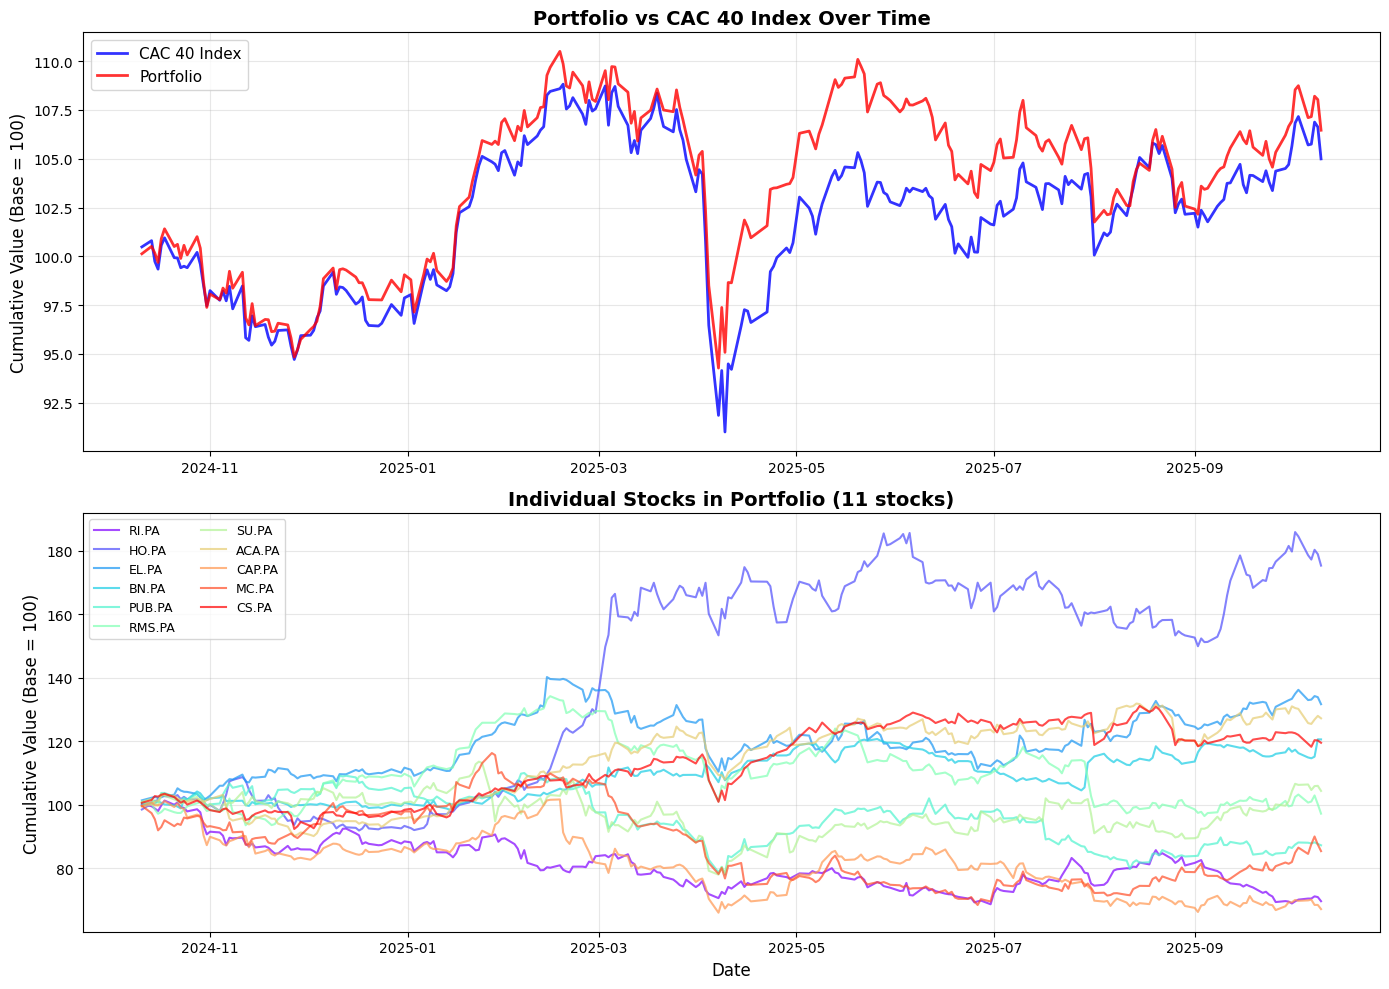


Final Values:
  Portfolio: 106.46
  Index:     104.99
  Difference: 1.47

Stocks in portfolio: RI.PA, HO.PA, EL.PA, BN.PA, PUB.PA, RMS.PA, SU.PA, ACA.PA, CAP.PA, MC.PA, CS.PA


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

stock_returns = stocks_df[stocks_df['name'].isin(best_stocks)].pivot(
    index='date', columns='name', values='daily_return_pct'
)
portfolio_returns = stock_returns.mean(axis=1)

# Get index returns
index_returns = index_df.set_index('date')['daily_return_pct']

# Align dates
common_dates = portfolio_returns.index.intersection(index_returns.index)
portfolio_returns = portfolio_returns.loc[common_dates]
index_returns = index_returns.loc[common_dates]

# Remove NaN values
valid_idx = ~(portfolio_returns.isna() | index_returns.isna())
portfolio_returns = portfolio_returns[valid_idx]
index_returns = index_returns[valid_idx]

# Calculate cumulative returns (starting at 100)
portfolio_cumulative = (1 + portfolio_returns).cumprod() * 100
index_cumulative = (1 + index_returns).cumprod() * 100

# ============================================================================
# TWO SUBPLOTS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ============================================================================
# SUBPLOT 1: Portfolio vs Index
# ============================================================================

ax1.plot(portfolio_cumulative.index, index_cumulative.values,
        label='CAC 40 Index', color='blue', linewidth=2, alpha=0.8)
ax1.plot(portfolio_cumulative.index, portfolio_cumulative.values,
        label='Portfolio', color='red', linewidth=2, alpha=0.8)

ax1.set_ylabel('Cumulative Value (Base = 100)', fontsize=12)
ax1.set_title('Portfolio vs CAC 40 Index Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# ============================================================================
# SUBPLOT 2: Individual Stocks in Portfolio
# ============================================================================

# Get individual stock returns for the selected portfolio
stock_returns_individual = stocks_df[stocks_df['name'].isin(best_stocks)].pivot(
    index='date', columns='name', values='daily_return_pct'
)

# Align with the same dates as portfolio (common_dates)
stock_returns_individual = stock_returns_individual.loc[portfolio_cumulative.index]

# Calculate cumulative returns for each stock (starting at 100)
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(best_stocks)))

for i, stock in enumerate(best_stocks):
    stock_data = stock_returns_individual[stock].dropna()

    # Make sure we start from the first valid date for this stock
    # and calculate cumulative from there, starting at 100
    stock_cumulative = (1 + stock_data).cumprod() * 100

    ax2.plot(stock_cumulative.index, stock_cumulative.values,
            label=stock, linewidth=1.5, alpha=0.7, color=colors[i])

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Cumulative Value (Base = 100)', fontsize=12)
ax2.set_title(f'Individual Stocks in Portfolio ({len(best_stocks)} stocks)',
             fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9, ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nFinal Values:")
print(f"  Portfolio: {portfolio_cumulative.iloc[-1]:.2f}")
print(f"  Index:     {index_cumulative.iloc[-1]:.2f}")
print(f"  Difference: {portfolio_cumulative.iloc[-1] - index_cumulative.iloc[-1]:.2f}")
print(f"\nStocks in portfolio: {', '.join(best_stocks)}")

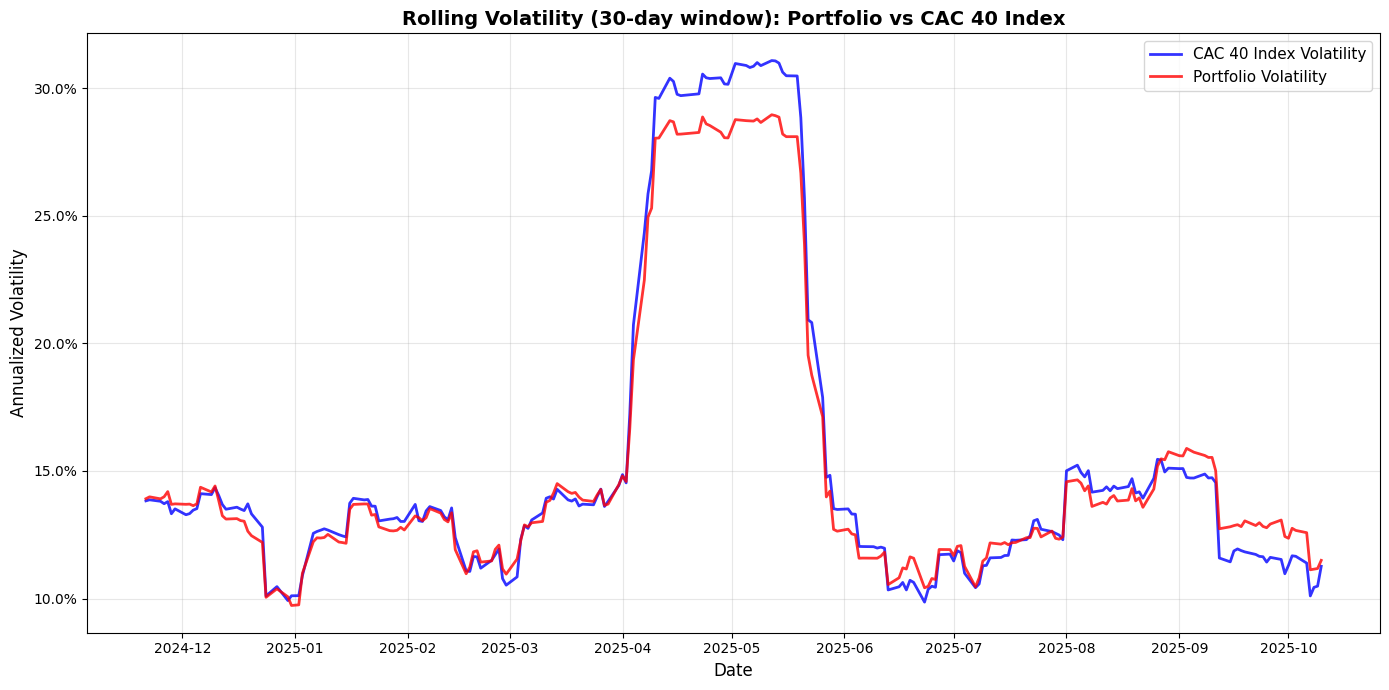


Average Volatility:
  Portfolio: 15.01%
  Index:     15.21%
  Difference: -0.21%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get portfolio returns
stock_returns = stocks_df[stocks_df['name'].isin(best_stocks)].pivot(
    index='date', columns='name', values='daily_return_pct'
)
portfolio_returns = stock_returns.mean(axis=1)

# Get index returns
index_returns = index_df.set_index('date')['daily_return_pct']

# Align dates
common_dates = portfolio_returns.index.intersection(index_returns.index)
portfolio_returns = portfolio_returns.loc[common_dates]
index_returns = index_returns.loc[common_dates]

# Remove NaN values
valid_idx = ~(portfolio_returns.isna() | index_returns.isna())
portfolio_returns = portfolio_returns[valid_idx]
index_returns = index_returns[valid_idx]

# Calculate rolling volatility (annualized, 30-day window)
window = 30
portfolio_volatility = portfolio_returns.rolling(window=window).std() * np.sqrt(252)
index_volatility = index_returns.rolling(window=window).std() * np.sqrt(252)

# Create plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(index_volatility.index, index_volatility.values,
        label='CAC 40 Index Volatility', color='blue', linewidth=2, alpha=0.8)
ax.plot(portfolio_volatility.index, portfolio_volatility.values,
        label='Portfolio Volatility', color='red', linewidth=2, alpha=0.8)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Annualized Volatility', fontsize=12)
ax.set_title(f'Rolling Volatility ({window}-day window): Portfolio vs CAC 40 Index',
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:.1%}'))

plt.tight_layout()
plt.show()

# Print summary stats
print(f"\nAverage Volatility:")
print(f"  Portfolio: {portfolio_volatility.mean():.2%}")
print(f"  Index:     {index_volatility.mean():.2%}")
print(f"  Difference: {portfolio_volatility.mean() - index_volatility.mean():.2%}")

In [ ]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
